## External

* Check out my Github where I have deployed this project as an app on Heroku
* The dataset for this project is available on my Kaggle profile

# Introduction

In machine learning, Transfer Learning is the process of using knowledge previously acquired by solving a problem on a new (current) problem, with or without changes to the knowledge.

This is possible because when a model is trained, the initial neurons of a CNN architecture extract only the high level information, which gets narrowed down to information about the specific classes with each neural layer. For example, if a model is trained to recognize flowers, it can be further trained to classify different flower species.

This is needed because it brings trained state-of-the-art models like VGG16, InceptionNet at the disposal of common users. These models have been trained for hundreds of hours on millions of images which is not possible for a dork sitting in his basement on his i5 processor.

So transfer learning comes to the rescue. From this notebook, you will learn how to make an image classifier using 4 models. The method of training the models is the same, so it shouldn't be much difficult if you learn just one.

# Importing Necessary Libraries

The following cell imports the necessary libraries required for this notebook.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Activation, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import applications

# Dataset

The directory structure is in the following form:
    
```
Train   
│
└───adonis
│   │   000.jpg
│   │   001.jpg
│   │   ...
│
└───american anoot
│   │   000.jpg
│   │   001.jpg
│   │   ...
│
└───an 88
│   │   000.jpg
│   │   001.jpg
│   │   ...
...
...

...
│
└───zebra long wing
    │   000.jpg
    │   001.jpg
    │   ...
```

# Data Visualization

This portion is just for visualization and data exploration.

The visualizations could have been done with Tensorflow's ImageDataGenerator, but exploration with the OS module and CV2 seemed easier.

In [ ]:
train = list(os.walk('/content/gdrive/MyDrive/Multi Class Image Classification/Train')) #gives the list of all directories and subdirectories

In [ ]:
label_names = train[0][1]
dict_labels = dict(zip(label_names, list(range(len(label_names)))))
print(dict_labels)

{'wood satyr': 0, 'ulyses': 1, 'yellow swallow tail': 2, 'viceroy': 3, 'sootywing': 4, 'southern dogface': 5, 'two barred flasher': 6, 'straited queen': 7, 'skipper': 8, 'zebra long wing': 9, 'peacock': 10, 'silver spot skipper': 11, 'red admiral': 12, 'pine white': 13, 'scarce swallow': 14, 'question mark': 15, 'pipevine swallow': 16, 'red spotted purple': 17, 'purple hairstreak': 18, 'sixspot burnet': 19, 'monarch': 20, 'morning cloak': 21, 'orchard swallow': 22, 'paper kite': 23, 'painted lady': 24, 'orange tip': 25, 'mangrove skipper': 26, 'orange oakleaf': 27, 'malachite': 28, 'metalmark': 29, 'eastern coma': 30, 'crimson patch': 31, 'gold banded': 32, 'crecent': 33, 'indra swallow': 34, 'large marble': 35, 'grey hairstreak': 36, 'copper tail': 37, 'julia': 38, 'great eggfly': 39, 'adonis': 40, 'banded peacock': 41, 'chestnut': 42, 'american snoot': 43, 'black hairstreak': 44, 'an 88': 45, 'beckers white': 46, 'clodius parnassian': 47, 'cabbage white': 48, 'clouded sulphur': 49}


THe next function takes in the outermost directory and returns np array of the images contained in each subdirectory along with their labels

In [ ]:
def dataset(path): #put path till the highest directory level
    images = []
    labels = []
    for folder in tqdm(os.listdir(path)):
        value_of_label = dict_labels[folder] #dict_labels is the dictionary whose key:value pairs are classes:numbers representing them

        for file in (os.listdir(os.path.join(path, folder))):
            path_of_file = os.path.join(os.path.join(path, folder), file)

            image = cv2.imread(path_of_file)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (150, 150))
            images.append(image)
            labels.append(value_of_label)

    images = np.array(images, dtype = 'float32')/255.0
    labels = np.array(labels)

    return images, labels

images, labels = dataset('/content/gdrive/MyDrive/Multi Class Image Classification/Train')
images, labels = shuffle(images, labels)

100%|██████████| 50/50 [16:52<00:00, 20.25s/it]


In [ ]:
images.shape

(4489, 150, 150, 3)

## This barplot shows the number of images of each species

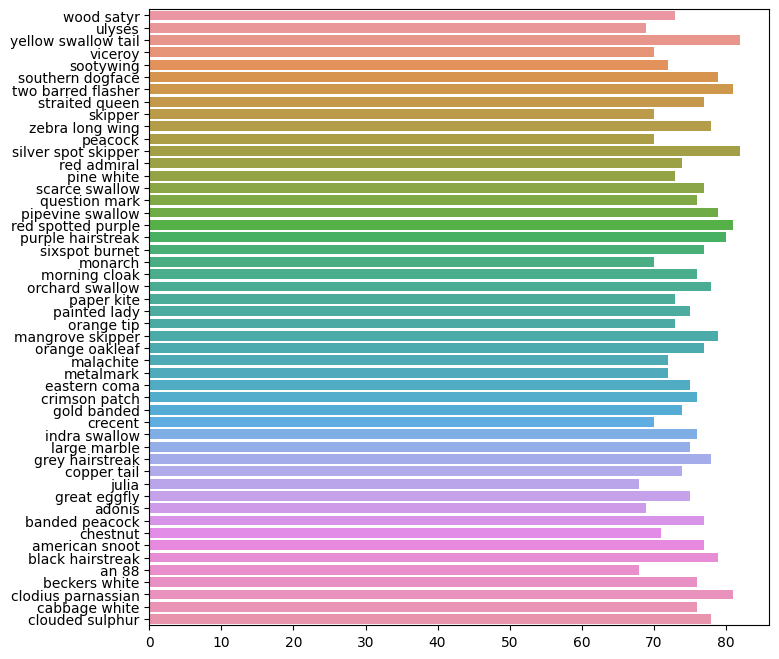

In [ ]:
species = train[0][1]
no_of_butterflies = []
for _ in range(1, 51):
    no_of_butterflies.append(len(train[_][0]))
plt.figure(figsize = (8, 8))
sns.barplot(y = species, x = no_of_butterflies);

## Sample images

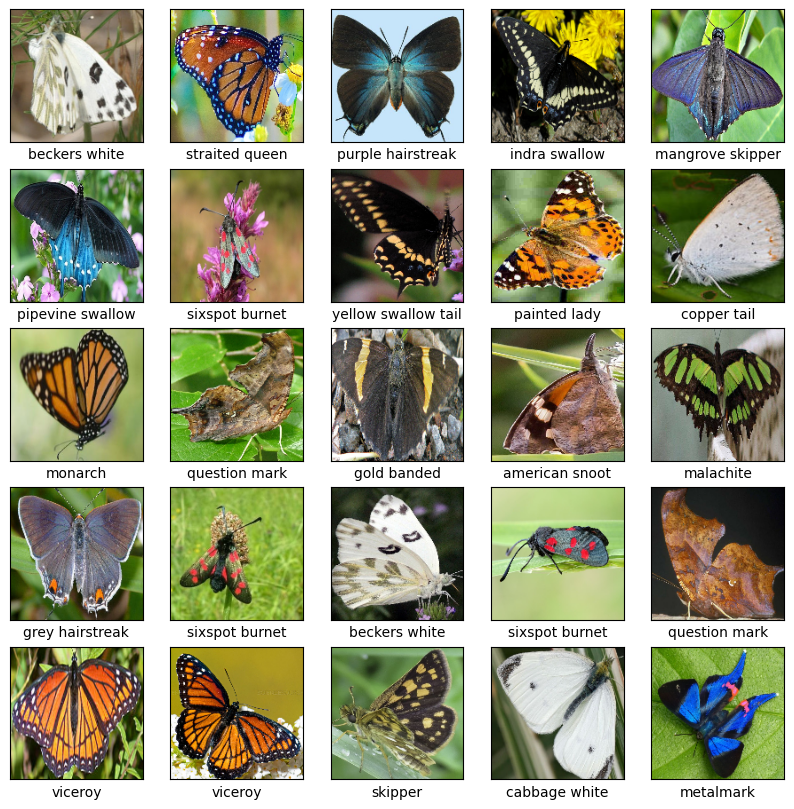

In [ ]:
plt.figure(figsize = (10,10))
for _ in range(25):
    plt.subplot(5, 5, _+1)
    plt.yticks([])
    plt.xticks([])
    plt.grid(False)
    data = images[_]
    plt.xlabel(label_names[labels[_]])
    plt.imshow(data);

# Load images using ImageDatagenerator

The best way to prepare the images for the model is by using the ImageDataGenerator. Create an object of the ImageDataGenerator and initialize the various parameters.

If the number of training samples is low, like in the current dataset, it's always better to set the shear_range, zoom_range, and the other image augmentations. This helps to avoid overfitting due to low data and makes the model more robust.

In [9]:
image_size = (224, 224)
batch_size = 64
train_datagen = ImageDataGenerator(rescale = 1./255,
                            shear_range = 0.4,
                            zoom_range = 0.4,
                            horizontal_flip = True,
                            vertical_flip = True,
                            validation_split = 0.2)

After this, use the flow_from_directory method to get the images from the directories to feed it into the models.

In [10]:
train_ds = train_datagen.flow_from_directory('/content/gdrive/MyDrive/Multi Class Image Classification/Train',
                                      target_size = image_size,
                                      batch_size = batch_size,
                                      class_mode = 'categorical',
                                      subset = 'training',
                                      color_mode="rgb",)

val_ds = train_datagen.flow_from_directory('/content/gdrive/MyDrive/Multi Class Image Classification/Train',
                                      target_size = image_size,
                                      batch_size = batch_size,
                                      class_mode = 'categorical',
                                      subset = 'validation',
                                      color_mode="rgb")

Found 3609 images belonging to 50 classes.
Found 880 images belonging to 50 classes.


In [11]:
train_ds.class_indices

{'adonis': 0,
 'american snoot': 1,
 'an 88': 2,
 'banded peacock': 3,
 'beckers white': 4,
 'black hairstreak': 5,
 'cabbage white': 6,
 'chestnut': 7,
 'clodius parnassian': 8,
 'clouded sulphur': 9,
 'copper tail': 10,
 'crecent': 11,
 'crimson patch': 12,
 'eastern coma': 13,
 'gold banded': 14,
 'great eggfly': 15,
 'grey hairstreak': 16,
 'indra swallow': 17,
 'julia': 18,
 'large marble': 19,
 'malachite': 20,
 'mangrove skipper': 21,
 'metalmark': 22,
 'monarch': 23,
 'morning cloak': 24,
 'orange oakleaf': 25,
 'orange tip': 26,
 'orchard swallow': 27,
 'painted lady': 28,
 'paper kite': 29,
 'peacock': 30,
 'pine white': 31,
 'pipevine swallow': 32,
 'purple hairstreak': 33,
 'question mark': 34,
 'red admiral': 35,
 'red spotted purple': 36,
 'scarce swallow': 37,
 'silver spot skipper': 38,
 'sixspot burnet': 39,
 'skipper': 40,
 'sootywing': 41,
 'southern dogface': 42,
 'straited queen': 43,
 'two barred flasher': 44,
 'ulyses': 45,
 'viceroy': 46,
 'wood satyr': 47,
 'ye

### Some augmented images

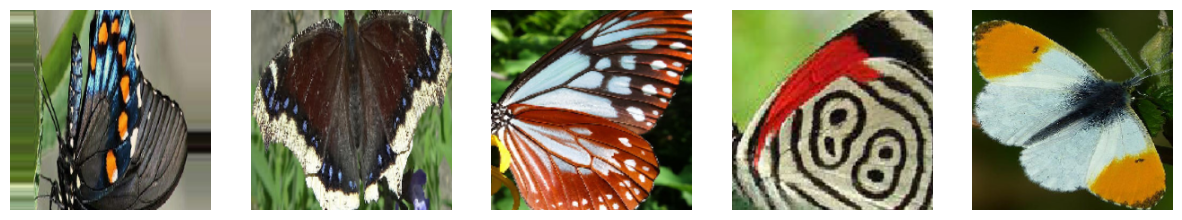

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15,15))

for i in range(5):
    image = next(train_ds)[0][0]
    image = np.squeeze(image)
    ax[i].imshow(image)
    ax[i].axis(False)

# Transfer learning

### VGG16

The first model here is the VGG16. It was trained on the imagenet dataset with 1000 classes. The include_top parameter is set False because our dataset has only 50 classes so the output layer has to be modified accordingly.

Also, trainable is set to False as we do not want to train the base model.

In [ ]:
vgg_base = applications.VGG16(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
vgg_base.trainable = False

In the summary, it can be seen that the base is VGG16, while the top is the one that is added.

In [ ]:
inputs = Input(shape=(224, 224, 3))

x = vgg_base(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation = 'relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(50, activation = 'sigmoid')(x)
vgg_model = Model(inputs, outputs)
vgg_model.summary

<bound method Model.summary of <keras.src.engine.functional.Functional object at 0x7f6f3d52d030>>

In [ ]:
vgg_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss= keras.losses.CategoricalCrossentropy(from_logits = True),
    metrics= [keras.metrics.CategoricalAccuracy()],
)

In [ ]:
epochs = 25
vgg_model.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5577: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


15/57 [======>.......................] - ETA: 49s - loss: 3.9871 - categorical_accuracy: 0.0292

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-21-3b23fd5ccdd0>", line 2, in <cell line: 2>
    vgg_model.fit(train_ds, epochs=epochs, validation_data=val_ds)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1783, in fit
    tmp_logs = self.train_function(iterator)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py", line 831, in __call__
    result = self._call(*args, **kwds)
  File "/usr/local/lib/python3.10/dist-packages/tensorfl

TypeError: ignored

In [ ]:
vgg_model.save('/content/gdrive/MyDrive/Multi Class Image Classification/vgg.hdf5') #this saves the model with the weights

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


And that's how the model is trained, the next 3 models have also been trained in a similar way.

You can try modifying the layers, input shape, activation function and see what you get.

## VGG - 2


In [ ]:
vgg_base2 = applications.VGG16(weights = 'imagenet', include_top = False, input_shape = (256, 256, 3))
vgg_base2.trainable = False

In [ ]:
inputs = Input(shape=(256, 256, 3))

x = vgg_base2(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation = 'relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(50, activation = 'sigmoid')(x)
vgg_model2 = Model(inputs, outputs)
vgg_model2.summary

<bound method Model.summary of <keras.src.engine.functional.Functional object at 0x7f6fd009ea10>>

In [ ]:
vgg_model2.compile(
    optimizer=keras.optimizers.Adam(),
    loss= keras.losses.CategoricalCrossentropy(from_logits = True),
    metrics= [keras.metrics.CategoricalAccuracy()],
)

In [ ]:
epochs = 25
vgg_model2.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/25
57/57 [==============================] - 94s 2s/step - loss: 3.7281 - categorical_accuracy: 0.1009 - val_loss: 3.2854 - val_categorical_accuracy: 0.3511
Epoch 2/25
57/57 [==============================] - 89s 2s/step - loss: 2.9710 - categorical_accuracy: 0.2937 - val_loss: 2.5637 - val_categorical_accuracy: 0.4443
Epoch 3/25
57/57 [==============================] - 96s 2s/step - loss: 2.3808 - categorical_accuracy: 0.4281 - val_loss: 2.0598 - val_categorical_accuracy: 0.5545
Epoch 4/25
57/57 [==============================] - 87s 2s/step - loss: 1.9733 - categorical_accuracy: 0.5054 - val_loss: 1.7558 - val_categorical_accuracy: 0.6011
Epoch 5/25
57/57 [==============================] - 87s 2s/step - loss: 1.7301 - categorical_accuracy: 0.5547 - val_loss: 1.5423 - val_categorical_accuracy: 0.6307
Epoch 6/25
57/57 [==============================] - 90s 2s/step - loss: 1.5411 - categorical_accuracy: 0.5860 - val_loss: 1.3865 - val_categorical_accuracy: 0.6648
Epoch 7/25
57/57

In [ ]:
vgg_model2.save('/content/gdrive/MyDrive/Multi Class Image Classification/vgg2.hdf5') #this saves the model with the weights

## VGG 19

In [ ]:
vgg_base19 = applications.VGG19(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
vgg_base19.trainable = False

80134624/80134624 [==============================] - 0s 0us/step


In [ ]:
inputs = Input(shape=(224, 224, 3))

x = vgg_base19(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation = 'relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(50, activation = 'sigmoid')(x)
vgg_model19 = Model(inputs, outputs)
vgg_model19.summary

<bound method Model.summary of <keras.src.engine.functional.Functional object at 0x7f6f3d28ce20>>

In [ ]:
vgg_model19.compile(
    optimizer=keras.optimizers.Adam(),
    loss= keras.losses.CategoricalCrossentropy(from_logits = True),
    metrics= [keras.metrics.CategoricalAccuracy()],
)

In [ ]:
epochs = 25
vgg_model19.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5577: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


57/57 [==============================] - 100s 2s/step - loss: 3.7538 - categorical_accuracy: 0.0856 - val_loss: 3.3641 - val_categorical_accuracy: 0.2432
Epoch 2/25
57/57 [==============================] - 88s 2s/step - loss: 3.1045 - categorical_accuracy: 0.2519 - val_loss: 2.7169 - val_categorical_accuracy: 0.4341
Epoch 3/25
57/57 [==============================] - 90s 2s/step - loss: 2.5834 - categorical_accuracy: 0.3680 - val_loss: 2.2493 - val_categorical_accuracy: 0.4966
Epoch 4/25
57/57 [==============================] - 93s 2s/step - loss: 2.1895 - categorical_accuracy: 0.4469 - val_loss: 1.9501 - val_categorical_accuracy: 0.5477
Epoch 5/25
57/57 [==============================] - 91s 2s/step - loss: 1.9208 - categorical_accuracy: 0.5062 - val_loss: 1.7289 - val_categorical_accuracy: 0.6011
Epoch 6/25
57/57 [==============================] - 90s 2s/step - loss: 1.7189 - categorical_accuracy: 0.5484 - val_loss: 1.5922 - val_categorical_accuracy: 0.6295
Epoch 7/25
57/57 [========

In [ ]:
vgg_model19.save('/content/gdrive/MyDrive/Multi Class Image Classification/vgg19.hdf5') #this saves the model with the weights

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Xception

In [ ]:
xcep_base = applications.Xception(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
xcep_base.trainable = False

inputs = Input(shape=(224, 224, 3))

x = xcep_base(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation = 'relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(50, activation = 'sigmoid')(x)
xcep_model = Model(inputs, outputs)

83683744/83683744 [==============================] - 1s 0us/step


In [ ]:
xcep_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss= keras.losses.CategoricalCrossentropy(from_logits = True),
    metrics= [keras.metrics.CategoricalAccuracy()],
)

In [ ]:
epochs = 25
xcep_model.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/25
57/57 [==============================] - 99s 2s/step - loss: 2.3716 - categorical_accuracy: 0.3766 - val_loss: 1.2874 - val_categorical_accuracy: 0.6625
Epoch 2/25
57/57 [==============================] - 88s 2s/step - loss: 1.2596 - categorical_accuracy: 0.6304 - val_loss: 0.9064 - val_categorical_accuracy: 0.7477
Epoch 3/25
57/57 [==============================] - 94s 2s/step - loss: 0.9770 - categorical_accuracy: 0.7005 - val_loss: 0.8373 - val_categorical_accuracy: 0.7568
Epoch 4/25
57/57 [==============================] - 88s 2s/step - loss: 0.8663 - categorical_accuracy: 0.7346 - val_loss: 0.8328 - val_categorical_accuracy: 0.7670
Epoch 5/25
57/57 [==============================] - 91s 2s/step - loss: 0.7800 - categorical_accuracy: 0.7581 - val_loss: 0.7117 - val_categorical_accuracy: 0.7955
Epoch 6/25
57/57 [==============================] - 91s 2s/step - loss: 0.7175 - categorical_accuracy: 0.7828 - val_loss: 0.6647 - val_categorical_accuracy: 0.8159
Epoch 7/25
57/57

In [ ]:
xcep_model.save('/content/gdrive/MyDrive/Multi Class Image Classification/xcep.hdf5')

### ResNet

In [ ]:
res_base = applications.ResNet152V2(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
res_base.trainable = False

inputs = Input(shape=(224, 224, 3))

x = res_base(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation = 'relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(50, activation = 'sigmoid')(x)
res_model = Model(inputs, outputs)

234545216/234545216 [==============================] - 1s 0us/step


In [ ]:
res_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss= keras.losses.CategoricalCrossentropy(from_logits = True),
    metrics= [keras.metrics.CategoricalAccuracy()],
)

In [ ]:
epochs = 25
res_model.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5577: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


57/57 [==============================] - 1304s 23s/step - loss: 2.0089 - categorical_accuracy: 0.4749 - val_loss: 0.8988 - val_categorical_accuracy: 0.7523
Epoch 2/25
57/57 [==============================] - 92s 2s/step - loss: 0.9254 - categorical_accuracy: 0.7296 - val_loss: 0.6308 - val_categorical_accuracy: 0.8205
Epoch 3/25
57/57 [==============================] - 92s 2s/step - loss: 0.7083 - categorical_accuracy: 0.7842 - val_loss: 0.5903 - val_categorical_accuracy: 0.8398
Epoch 4/25
57/57 [==============================] - 93s 2s/step - loss: 0.6256 - categorical_accuracy: 0.8105 - val_loss: 0.5835 - val_categorical_accuracy: 0.8375
Epoch 5/25
57/57 [==============================] - 94s 2s/step - loss: 0.5850 - categorical_accuracy: 0.8216 - val_loss: 0.5355 - val_categorical_accuracy: 0.8636
Epoch 6/25
57/57 [==============================] - 93s 2s/step - loss: 0.4821 - categorical_accuracy: 0.8531 - val_loss: 0.4793 - val_categorical_accuracy: 0.8614
Epoch 7/25
57/57 [======

In [ ]:
res_model.save('/content/gdrive/MyDrive/Multi Class Image Classification/res.hdf5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Inception V3

In [12]:
incep_base = applications.InceptionV3(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
incep_base.trainable = False

inputs = Input(shape=(224, 224, 3))

x = incep_base(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation = 'relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(50, activation = 'sigmoid')(x)
incep_model = Model(inputs, outputs)

In [13]:
incep_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss= keras.losses.CategoricalCrossentropy(from_logits = True),
    metrics= [keras.metrics.CategoricalAccuracy()],
)

In [14]:
epochs = 25
incep_model.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5577: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


57/57 [==============================] - 2319s 41s/step - loss: 2.7913 - categorical_accuracy: 0.2962 - val_loss: 1.6201 - val_categorical_accuracy: 0.5818
Epoch 2/25
57/57 [==============================] - 91s 2s/step - loss: 1.6087 - categorical_accuracy: 0.5292 - val_loss: 1.2105 - val_categorical_accuracy: 0.6716
Epoch 3/25
57/57 [==============================] - 89s 2s/step - loss: 1.2931 - categorical_accuracy: 0.6212 - val_loss: 1.0242 - val_categorical_accuracy: 0.7148
Epoch 4/25
57/57 [==============================] - 90s 2s/step - loss: 1.1050 - categorical_accuracy: 0.6675 - val_loss: 0.9599 - val_categorical_accuracy: 0.7307
Epoch 5/25
57/57 [==============================] - 92s 2s/step - loss: 1.0231 - categorical_accuracy: 0.6960 - val_loss: 0.8745 - val_categorical_accuracy: 0.7420
Epoch 6/25
57/57 [==============================] - 88s 2s/step - loss: 0.9621 - categorical_accuracy: 0.7113 - val_loss: 0.8375 - val_categorical_accuracy: 0.7670
Epoch 7/25
57/57 [======

In [16]:
incep_model.save('/content/gdrive/MyDrive/Multi Class Image Classification/incep.hdf5')

# Testing Model on Own Image

This function preprocesses the image so that it can be fed into the trained models.

You can train the above models and pick an image and plug it into the predictor function to get the output.

In [ ]:
def predictor(img, model):
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    image = np.array(image, dtype = 'float32')/255.0
    plt.imshow(image)
    image = image.reshape(1, 224,224,3)

    label_names = train_ds.class_indices
    dict_class = dict(zip(list(range(len(label_names))), label_names))
    clas = model.predict(image).argmax()
    name = dict_class[clas]
    print('The given image is of \nClass: {0} \nSpecies: {1}'.format(clas, name))

The given image is of 
Class: 2 
Species: an 88


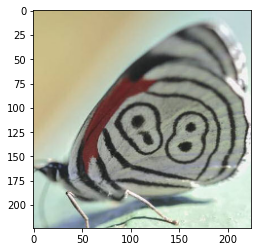

In [ ]:
predictor('../input/butterfly-classification-dataset/Train/an 88/076.jpg', res_model) #example image

# Loading model

Use the following code to load a saved model.

In [ ]:
#modelSaved = keras.models.load_model('./inception.hdf5')